# Example 4 - Manually reconstruct MLA data

This script illustrates how to reconstruct the MLA data using the low-level functions inside the ``mla_reconstruction`` library. The different data processing steps are grouped in sub sections and commented to provide insight on how they work.

The different sub sections are

1. Import the phase & amplitude corrections

2. Load a data block

3. Extract FFT coefficents and apply amp&phase corrections

4. current and conductance reconstruction



In [2]:
import os
import sys

import h5py
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [3]:
# ====================
# load mla python library
# ====================
repo_dir = os.path.dirname(os.getcwd())

src_dir = os.path.join(
    repo_dir,
    'src'
)

if src_dir not in sys.path:
    sys.path.append(src_dir)

from mla_reconstruction import _create_block_list, _get_data_block_list, _parse_all_data_blocks
from mla_reconstruction import _convert_to_polar_coordinates, _add_amplitude_and_phase_correction, _convert_to_rectangular_coordinates
from mla_reconstruction import get_measurement_data, get_energy_spectra
from mla_reconstruction import _load_mla_data_into_hdf5, _load_mla_data_header, _read_one_block
from mla_reconstruction import add_dc_value_to_fft_coeff_array

In [4]:
# ======================
# load data
# ======================
exmpl_dir = 'examples'
data_dir = 'test_data'
data_subdir = '20210604_MLA_DCoffset_test'

mla_txt_fn = os.path.join(
    repo_dir,
    exmpl_dir,
    data_dir,
    data_subdir,
    'Measurement of 2021-06-04 1734.txt'
)

mla_fn = mla_txt_fn.replace('.txt', '.hdf5')

## Import phase & amplitude corrections

In [5]:
# =======================
# load amplitude and Phase calibration values
# =======================
calib_dir = os.path.join(
    repo_dir,
    'mla_calib'
)
if calib_dir not in sys.path:
    sys.path.append(calib_dir)

from mla_calib_20210323 import AMPLITUDE_LAG as amp_lag_0323
from mla_calib_20210323 import PHASE_LAG as phase_lag_0323

## Load data from text file

In [6]:
# open txt file and create File hanlde
f_txt = open(mla_txt_fn, 'r')

# Load the measurement parameter 
prm_ = _load_mla_data_header(f_txt, pixel_number=1000)

# read the first block
block_lines = _read_one_block(f_txt)
block_list = _create_block_list(block_lines)
data_blocks = _get_data_block_list(block_list)

## Exract measured FFT coefficients and apply corrections
Data extraction and the application of phase and amplitude corrections is done inside the function ``get_measurement_data(..)``. The different processing steps are split up in helper functions as listed here:

- ``_parse_all_data_blocks( )``
- ``apply_amplitude_and_phase_correction( )``
    - ``_convert_to_polar_coordinates( )``
    - ``_add_amplitude_and_phase_correction( )``
    - ``_convert_to_rectangular_coordinates( )``
    
    
### Detailed explanation about the helper functions
 
``_parse_all_data_blocks( )``:
> parses the measured MLA FFT coefficients from the given text blocks to a complex-valued 2d arrays where every value represents one FFT coefficient. This step only parse, no data processing happens here.

``apply_amplitude_and_phase_correction( )``:
> This function converts the given dataset from complex rectangular coordinates to polar coordinates, applies a phase (additive) and ampltude (multiplicative) correction, and converts back to rectangular coordinates. The functions used for the transformation (``cmath.polar`` and ``cmath.rect``) use the *radiant representation* of polar coordinates. The function ``_add_amplitude_and_phase_correction( )`` takes the phase correction (variable ``phase_lag``) in *degree*. This variable is then internally converted from degree to radiant to match the values provided from the ``cmath`` transformation functions.




In [7]:
# reconstruct measurement data
arr_ = get_measurement_data(
    data_blocks,
    prm_,
    deviation=None,
    phase_lag=phase_lag_0323,
    amplitude_lag=amp_lag_0323
)

In [9]:
# ==================================================================
# inside get_measurement_datat(..) the following functions are executed
# ==================================================================

# =================
# 1. extract data from txt-block
# =================
dset, dc_value = _parse_all_data_blocks(block_list, prm_['demodnum'])

# =================
# 2. apply_amplitude_and_phase_correction
# =================

# 2.1 convert from cartesian to polar coordinates
dset_p = _convert_to_polar_coordinates(dset)

# 2.2 add amp & phase correction
dset_p, devi_, amp_lag_, pase_lag_ = _add_amplitude_and_phase_correction(
    dset_p,
    deviation=None,
    phase_lag=phase_lag_0323,
    amplitude_lag=amp_lag_0323
)
# 2.3 convert back from polar to cartesian coordinates
dset_rect = _convert_to_rectangular_coordinates(dset_p)

dset_rect = add_dc_value_to_fft_coeff_array(dset_rect, dc_value, nanonis_current_offset=0)

                  dc-value:  0.677215


## Reconstruct the energy specta 

This computation steps are conducted inside the ``get_energy_spectra( )`` function. This function calls the following helper functions inside:

* ``setup_reconstruction_parameter( )``
* ``reconstruct_energy_spectra( )``
    * ``get_linear_energy( )``
    * ``_reconstruct_current_from_fft_coefficients( )``
    * ``_calc_current_interpolation( )``
    * ``_calc_conductance_from_current( )``

### Detailed explanation about the helper functions

``setup_reconstructoin_parameter( )``:
> computes the time, voltage and indeces values required for the current reconstruction and interpolation. The computed values inhere are derived from the MLA measurement parameters (e.g. ``modamp``, ``demod_freqs``, ``offset``, ``srate``, ...).

``reconstruct_energy_spectra( )``
> reconstructs the current over voltage trace from the FFT coefficents and interpolates the obtained fwd and bwd trace to obtain a current curve equally spaced over the modulated bias range. The corresponding conductance curve is obtained by numerically differentiating the current trace with ``np.diff``

   * ``get_linearized_energy( )``: returns equally spaced bias values derived from ``modamp``, ``offset``, and the specified energy resolution ``e_res``
   
   
   * ``_reconstruct_current_from_fft_coefficients( )``: is done using the ``np.fft.ifft( )`` function. The obtained complex current values are converted to real values with ``np.real( )``. 
   
   
   * ``_calc_current_interpolation( )``: is done using ``scipy.interpolate.interp1d( )``. The function allows to specify which part of the current trace should be used for reconstruction (e.g. fwd, back, or both). 
   
   
   * ``_calc_conductance_from_current( )``: are calculated by numerically differentiating the interpolated current trace using ``np.diff( )``.


In [10]:
from mla_reconstruction import _setup_reconstruction_parameter, reconstruct_energy_spectra, get_linearized_energy
from mla_reconstruction import _reconstruct_current_from_fft_coefficients
from mla_reconstruction import _calc_current_interpolation
from mla_reconstruction import _calc_conductance_from_current
from mla_reconstruction import _adjust_reconstruction_idcs_to_dc_value

# ==================================================================
# inside reconstruct_energy_spectra(..) the following functions are executed
# ==================================================================
e_res = 0.005

# =================
# 1. setup reconstruction parameter
# =================
t, v_t, first_index, last_index, step_size = _setup_reconstruction_parameter(**prm_)

# =================
# 2. reconstruction routine
# =================

# 2.1. get linearized energy values
lin_en = get_linearized_energy(prm_, e_res=e_res)

# 2.2 adjust indeces
first_index, last_index = _adjust_reconstruction_idcs_to_dc_value(dset_rect, first_index, last_index, step_size)

# 2.3 reconstruct the current
recon_pixels_amp = _reconstruct_current_from_fft_coefficients(dset_rect, prm_, first_index, last_index, step_size)

# 2.4 calculate the interpolated current trace
f = _calc_current_interpolation(recon_pixels_amp, prm_, v_t, use_trace='bwd')
curr_ = f(lin_en)

# 2.5 calculate conductance values
cond = _calc_conductance_from_current(f, lin_en)


In [11]:
# =================
# 2. reconstruction routine
# =================
lin_en, curr, cond = reconstruct_energy_spectra(
    dset_rect, prm_, t, v_t, 1, last_index, step_size
)

## Plot the results

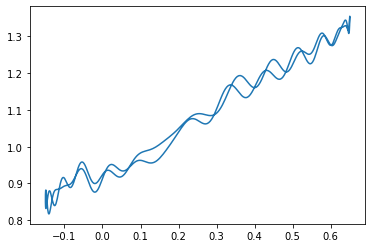

In [12]:
plt.plot(v_t, recon_pixels_amp)

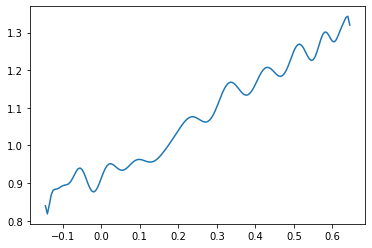

In [13]:
plt.plot(lin_en, cond.reshape((-1)))

In [14]:
f_txt.close()